In [1]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, uniform
from jax.numpy.linalg import eig, inv, matrix_power
from jax.scipy.signal import convolve

In [2]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C

def discretize(A, B, C, step):
    I = jnp.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, jnp.newaxis], jnp.zeros((N,)))[1]

def example_mass(k, b, m):
    A = jnp.array([[0, 1], [-k / m, -b / m]])
    B = jnp.array([[0], [1.0 / m]])
    C = jnp.array([[1.0, 0]])
    return A, B, C

@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = jnp.sin(10 * t)
    return x * (x > 0.5)



NameError: name 'np' is not defined

In [ ]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = jnp.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("line.gif", dpi=150, writer="imagemagick")

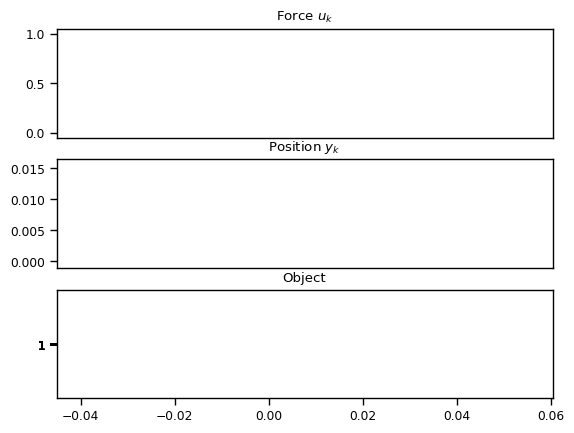

In [ ]:
if True:
    example_ssm()  

In [ ]:
def K_conv(Ab, Bb, Cb, L):
    return jnp.array(
        [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
    )

In [ ]:
def non_circular_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = jnp.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = jnp.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return jnp.fft.irfft(out)[: u.shape[0]]

In [ ]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = non_circular_convolution(u, K_conv(*ssmb, L))

    # Check
    assert jnp.allclose(rec.ravel(), conv.ravel())

In [ ]:
def make_HiPPO(N):
    def v(n, k):
        if n > k:
            return jnp.sqrt(2 * n + 1) * jnp.sqrt(2 * k + 1)
        elif n == k:
            return n + 1
        else:
            return 0

    # Do it slow so we don't mess it up :)
    mat = [[v(n, k) for k in range(1, N + 1)] for n in range(1, N + 1)]
    return jnp.array(mat)

In [ ]:
def example_legendre(N=8):
    # Random hidden state as coefficients
    import numpy as np
    import numpy.polynomial.legendre

    x = (np.random.rand(N) - 0.5) * 2
    t = np.linspace(-1, 1, 100)
    f = numpy.polynomial.legendre.Legendre(x)(t)

    # Plot
    import matplotlib.pyplot as plt
    import seaborn

    seaborn.set_context("talk")
    fig = plt.figure(figsize=(20, 10))
    # ax = fig.gca(projection="3d")
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(
        np.linspace(-25, (N - 1) * 100 + 25, 100),
        [0] * 100,
        zs=-1,
        zdir="x",
        color="black",
    )
    ax.plot(t, f, zs=N * 100, zdir="y", c="r")
    for i in range(N):
        coef = [0] * N
        coef[N - i - 1] = 1
        ax.set_zlim(-4, 4)
        ax.set_yticks([])
        ax.set_zticks([])
        # Plot basis function.
        f = numpy.polynomial.legendre.Legendre(coef)(t)
        ax.bar(
            [100 * i],
            [x[i]],
            zs=-1,
            zdir="x",
            label="x%d" % i,
            color="brown",
            fill=False,
            width=50,
        )
        ax.plot(t, f, zs=100 * i, zdir="y", c="b", alpha=0.5)
    ax.view_init(elev=40.0, azim=-45)
    fig.savefig("images/leg.png")

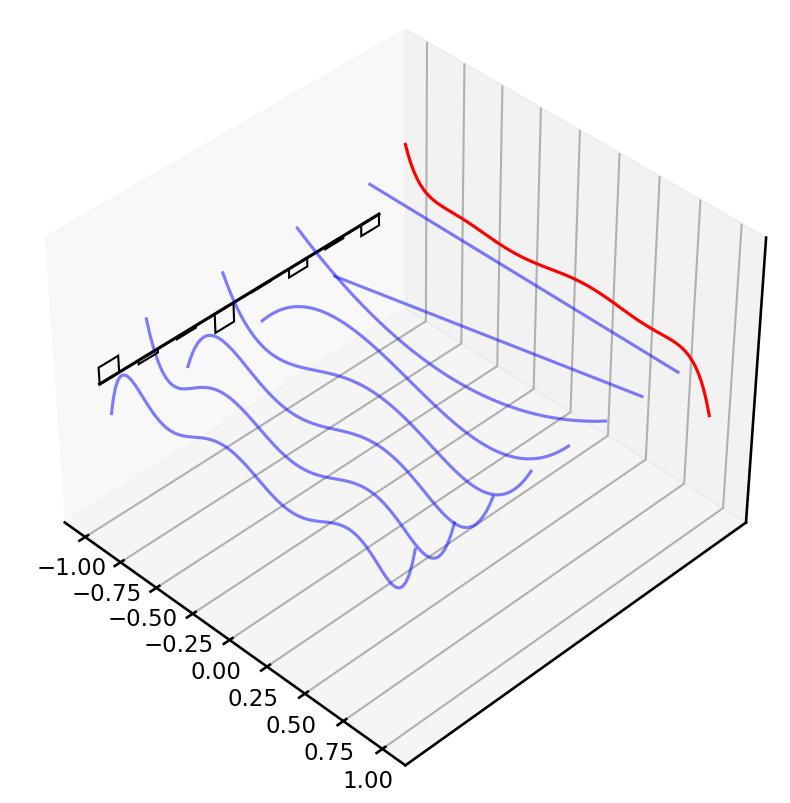

In [ ]:
example_legendre()

In [ ]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            jnp.log(dt_max) - jnp.log(dt_min)
        ) + jnp.log(dt_min)

    return init

In [ ]:
class SSMLayer(nn.Module):
    A: jnp.Array  # HiPPO
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", nn.initializers.ones, (1,))

        # Step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))

        step = jnp.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable("cache", "cache_x_k", jnp.zeros, (self.N,))

    def __call__(self, u):
        if not self.decode:
            # CNN Mode
            return non_circular_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, j   np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

AttributeError: module 'jax.numpy' has no attribute 'DeviceArray'